# 1. Extract data

In [206]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [207]:
def get_from_instant_data(df, windows_length):
    """
    Purpose: 以瞬间性event的波形最大值为定位点提取windows_length长的数据
    
    split=0.2 表示最大值左边取0.2*windows_length的数据
    """
    split = 0.2
    maxindex = df.idxmax(axis = 0)
    begin = int(maxindex - windows_length * split)
    end = int(maxindex + windows_length * (1 - split))
    return df[begin:end].reset_index(drop=True)

def get_from_persistent_data(df, windows_length):
    """
    Purpose: 从持续性event波形随机提取seq个windows_length长的数据
    """
    frequence = 2000
    time = len(df)/frequence
    df_list = []
    if time < 10:
        seq = 2
    elif time < 25:
        seq = 7
    elif time < 35:
        seq = 10
    else:
        seq = 20
    for i in range(seq):
        begin = int(len(df) // (seq+1) *(i+1))
        end = int(begin + windows_length)
        df_list.append(df[begin:end].reset_index(drop=True))
    df = pd.concat(df_list, axis = 1)
    return df

#def get_from_light_df_data(df)

In [208]:
def get_from_raw_data(datapath, dr):
    """
    Purpose: 提取一个event的数据
    Input: datapath\dr 是一个event的保存路径，如.\data3-29\CloseOutDoor
    Outp: df_of_one_event, 每一列为一次数据，列名为标签
    
    window_time为一次数据时间长度
    frequence为采样频率
    """
    window_time = 0.5
    frequence = 2000
    
    #瞬间性event标签集合
    instant_data_labels = ['CloseOutDoor', 'CloseKitchenDoor','CloseToiletDoor']
    #持续性event标签集合
    persistent_data_labels = ['WashHand','Bathe','FlushToilet','MicrowaveOven','BoilWater','InductionCooker','NoAppliance']
    #开关灯记录集合
    light_data_labels= ['KitchenLight']
    
    windows_length = window_time * frequence
    files = os.listdir(datapath + '\\' + dr)
    label = dr
    df_list = []
    for file in files:
        #print(datapath + '\\' + dr + '\\' +file)
        #file_name = datapath + '\\' + dr + '\\' +file    
        df = pd.read_csv(datapath + '\\' + dr + '\\' +file, header = 0,  usecols = ['mean_raw_ADC'])
        df.rename(columns = {'mean_raw_ADC':label}, inplace = True)
        
        # dc转化为ac
        df = df - df.mean(axis = 0) 
        
        #瞬间性和持续性event数据提取方法不同
        if dr in instant_data_labels:
            df = get_from_instant_data(df, windows_length)
        elif dr in persistent_data_labels:
            df = get_from_persistent_data(df, windows_length)
        #elif dr in light_data_list:
        #    df = get_from_light_df_data(df, windows_length)
        else:
            raise RuntimeError('event out of range')
        df_list.append(df)
    df_of_one_event = pd.concat(df_list, axis = 1)
    return df_of_one_event

In [209]:
def extract_data_from_dir(datapath):
    """
    Purpose: 从保存所有event的文件夹中提取出同样长度的数据
    Input: datapath是保存event的文件夹，其格式如：
                    .\data3-29
                    ----CloseOutDoor
                    ----------1001sample1.csv
    Output: event_all,为dataframe格式，每一列为一次数据，列名为其event标签
    """
    if not os.path.exists(datapath):
        raise RuntimeError('dir not exist')
        
    #保存数据的list，每个为一种event的df
    event_list = []
    dirs = os.listdir(datapath)
    
    #dr： event name
    for dr in dirs:
        if not os.path.isdir(datapath + '\\' + dr) :
                continue
        #print(dr + ' ready')
        df_of_one_event = get_from_raw_data(datapath, dr)
        
        #drop colunms with NAN
        df_of_one_event.dropna(axis=1,how='any',inplace = True)
        event_list.append(df_of_one_event)
        print(dr+'--%d completed'% df_of_one_event.shape[1])
        
    event_all = pd.concat(event_list, axis = 1)
    print()
    print('event_all shape: ', end = '')
    print(event_all.shape)
    print('NAN number: %d' % event_all.isnull().sum().sum())
    return event_all

In [210]:
#获取数据
event_all = extract_data_from_dir(".\data3-29")
event_all.head()

Bathe--24 completed
CloseKitchenDoor--10 completed
CloseOutDoor--20 completed
CloseToiletDoor--11 completed
FlushToilet--21 completed
NoAppliance--20 completed
WashHand--22 completed

event_all shape: (1000, 128)
NAN number: 0


,Bathe,Bathe,Bathe,Bathe,Bathe,Bathe,Bathe,Bathe,Bathe,Bathe,...,WashHand,WashHand,WashHand,WashHand,WashHand,WashHand,WashHand,WashHand,WashHand,WashHand
0,421.245364,34.245364,-292.565808,-293.565808,884.251469,-289.748531,-114.789209,-55.789209,-321.746646,-338.746646,...,167.982615,262.982615,-211.892018,56.107982,6.359063,-104.640937,70.368469,-77.631531,-228.947027,120.052973
1,443.245364,374.245364,286.434192,-165.565808,416.251469,102.251469,-231.789209,-193.789209,-81.746646,-672.746646,...,85.982615,195.982615,-179.892018,-122.892018,-33.640937,-119.640937,73.368469,-225.631531,-373.947027,182.052973
2,376.245364,603.245364,428.434192,130.434192,299.251469,299.251469,-25.789209,-357.789209,225.253354,-345.746646,...,-18.017385,137.982615,-128.892018,-284.892018,-31.640937,-126.640937,39.368469,-226.631531,-339.947027,169.052973
3,444.245364,796.245364,593.434192,279.434192,-181.748531,468.251469,-104.789209,-532.789209,400.253354,-3.746646,...,-96.017385,71.982615,10.107982,-294.892018,-55.640937,-50.640937,26.368469,-115.631531,-171.947027,118.052973
4,282.245364,516.245364,605.434192,213.434192,-708.748531,247.251469,-196.789209,-406.789209,457.253354,135.253354,...,-139.017385,-36.017385,92.107982,-136.892018,-114.640937,20.359063,-8.631531,30.368469,9.052973,-36.947027


# 2. Extract featrue

简单看下傅里叶变换后的波形特点

In [211]:
from scipy.fftpack import fft

def plot_fft(y, Title = '', Fs = 2000):
    """
    画出原图与傅里叶变换后图
    input:
        y  - data
        Fs - sampling rate采样率
    """
    T = len(y) / Fs
    Ts = 1/Fs; # sampling interval 采样周期
    x = np.arange(0, T, Ts) # time vector
    
    f1 = plt.figure(1)
    f1.set_size_inches(14, 3)
    
    plt.subplot(121)
    yy=rfft(y)  
    yf=abs(fft(y))                # 取绝对值
    yf1=yf/len(x)           #归一化处理
    yf2 = yf1[range(int(len(x)/2))]  #由于对称性，只取一半区间    
    plt.plot(x, y)
    plt.title(Title + ': raw data')
    
    plt.subplot(122)
    xf = np.arange(len(y))        # 频率
    xf1 = xf
    xf2 = xf[range(int(len(x)/2))]  #取一半区间
    plt.plot(xf2, yf2)
    plt.title(Title + ': fft')
    
    plt.show()

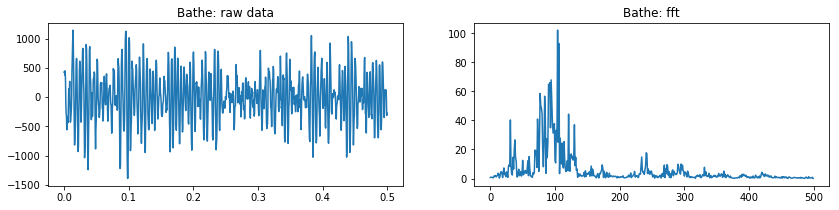

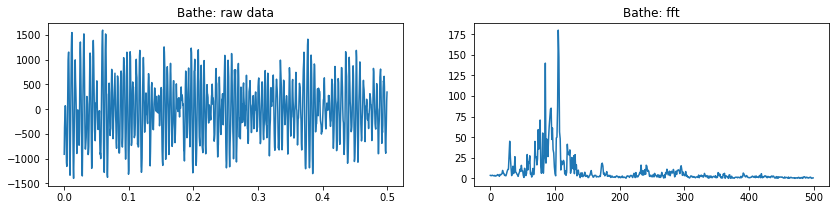

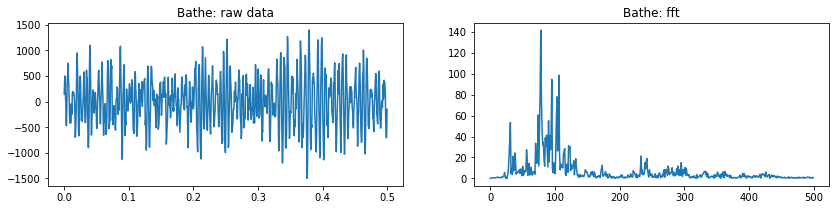

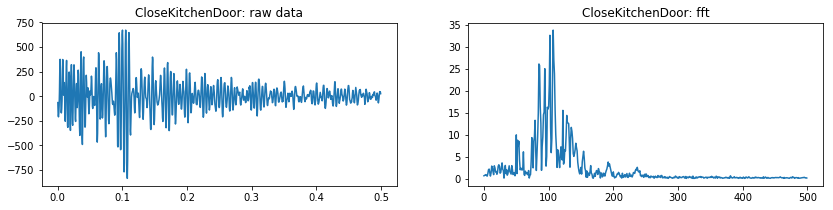

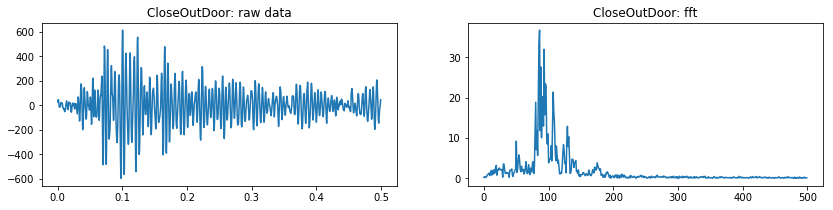

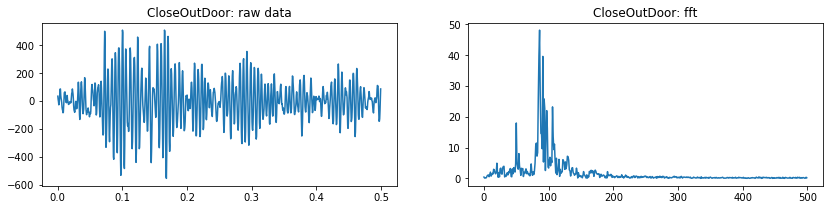

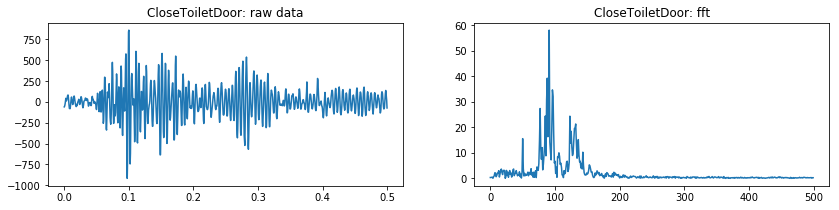

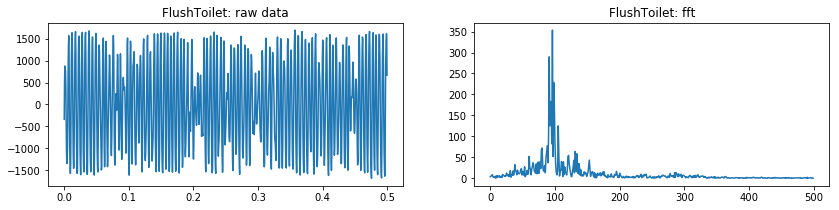

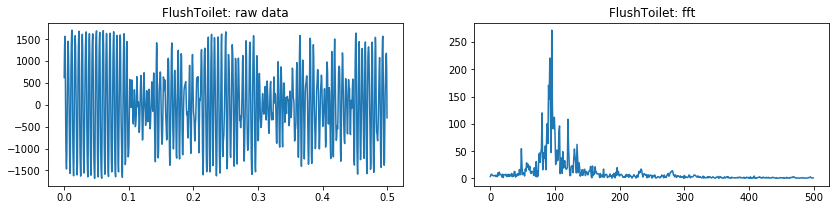

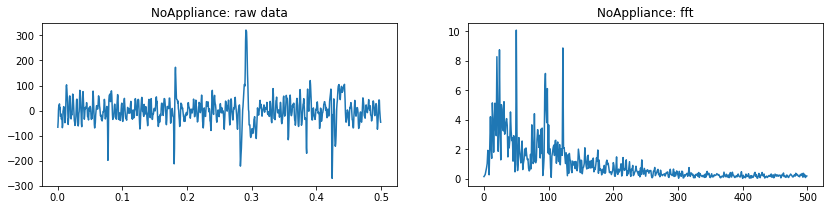

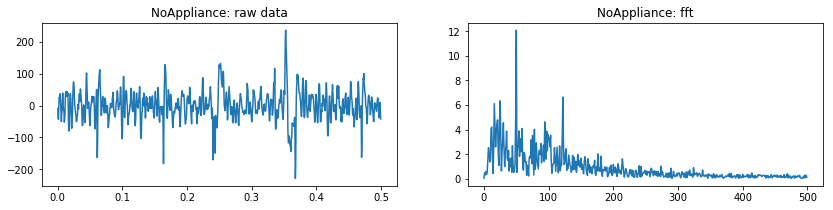

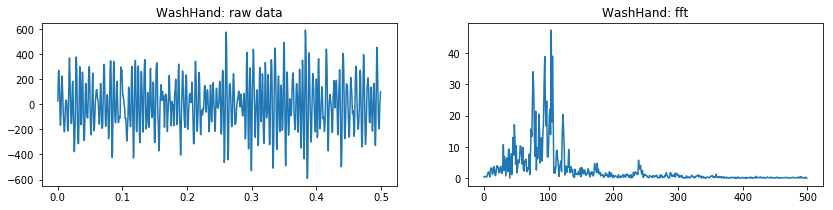

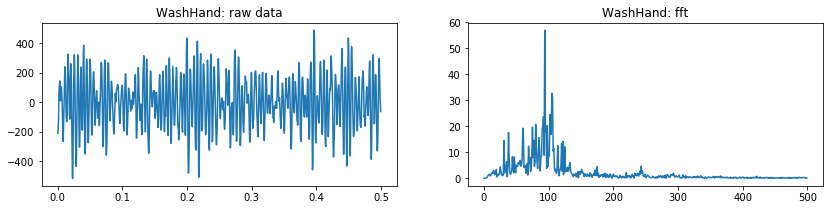

In [212]:
for i in range(0,event_all.shape[1],10):
    y = event_all.iloc[:,i].values
    title = event_all.columns.values.tolist()[i]
    plot_fft(y, title)

In [213]:
import scipy.stats as stats

def extract_feature(event_all):
    """
    Purpose: 提取特征
    Input：event_all为dataframe，每一列为一次数据，列名为标签
    output：feature_all为dataframe，每一行一次数据，记录了特征及标签，列名为特征名和label
            feature_all_names, feature_all的列名
    """
    
    #时域特征
    #mad = event_all.mad(axis=0).reset_index(drop=True)  #与std重复
    mean = event_all.mean(axis=0).reset_index(drop=True)
    std = event_all.std(axis=0).reset_index(drop=True)
    skew = event_all.skew(axis=0).reset_index(drop=True)
    kurt = event_all.kurt(axis=0).reset_index(drop=True)
    #max_ = event_all.max(axis=0).reset_index(drop=True)
   

    #频域特征
    #fft变换,每一列为一次数据的fft变换, 返回array
    fft_df = abs(fft(event_all, axis = 0))    #(n_featrue,  n_samples)
    #mean_fft = pd.Series(np.mean(fft_df, axis = 0))
    #max_fft = pd.Series(np.max(fft_df, axis = 0))
    #std_fft = pd.Series(np.std(fft_df, axis = 0))
    #ptp_fft = pd.Series(np.ptp(fft_df, axis = 0))
    max_index_fft = pd.Series(np.argmax(fft_df, axis = 0))
    
    #整合
    feature_all = pd.concat([mean, std, skew, kurt, max_index_fft], axis = 1)
    feature_all['label'] = event_all.columns.tolist()
    feature_and_label_names = ['mean','std', 'skew', 'kurt', 'max_index_fft','label']
    feature_all.columns = feature_and_label_names
    print('NAN number in feature_all: %d' % feature_all.isnull().sum().sum())
    return feature_all, feature_and_label_names

In [214]:
#提取特征
feature_all, feature_and_label_names = extract_feature(event_all)
feature_all.head()

NAN number in feature_all: 0


,mean,std,skew,kurt,max_index_fft,label
0,0.736364,417.010117,-0.108784,-0.003436,104,Bathe
1,0.672364,419.813871,0.030572,-0.286475,94,Bathe
2,0.559192,391.155483,-0.066394,0.084525,106,Bathe
3,-1.307808,424.975693,0.022003,-0.320261,105,Bathe
4,2.493469,515.602387,0.027497,-0.156131,106,Bathe


In [215]:
import seaborn as sns

def plot_pearson_correlation(featrue_no_label):
    """
    Purpose: plot the pearsoncorrelation of featrues
    Input:   feature_all为dataframe，每一行一次数据，记录了特征，列名为特征名
    """
    colormap = plt.cm.RdBu
    plt.figure(figsize=(5,4))
    plt.title('Pearson Correlation of Features', y=1.05)
    sns.heatmap(featrue_no_label.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)

    plt.show()

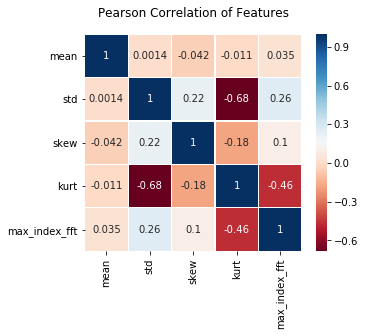

In [216]:
plot_pearson_correlation(feature_all.drop(["label"], axis=1))

# 3. Classification

In [217]:
print(feature_and_label_names)
feature_all.head() 

['mean', 'std', 'skew', 'kurt', 'max_index_fft', 'label']


,mean,std,skew,kurt,max_index_fft,label
0,0.736364,417.010117,-0.108784,-0.003436,104,Bathe
1,0.672364,419.813871,0.030572,-0.286475,94,Bathe
2,0.559192,391.155483,-0.066394,0.084525,106,Bathe
3,-1.307808,424.975693,0.022003,-0.320261,105,Bathe
4,2.493469,515.602387,0.027497,-0.156131,106,Bathe


In [218]:
from sklearn.model_selection import train_test_split

def data_split_according_label(feature_all, shuffle = True):
    """
    Purpose: 根据label将数据集分为训练集和测试集
    Input:   feature_all为dataframe，每一行一次数据，为特征和label
    Output:  feature_all_train, feature_all_test
    """
    
    all_label = list(set(feature_all.label.tolist()))
    train_list = []
    test_list = []
    for label in all_label:
        feature_ = feature_all[feature_all.label == label]
        feature_train, feature_test = train_test_split(feature_,test_size=0.25)
        train_list.append(feature_train)
        test_list.append(feature_test)
    
    feature_all_train = pd.concat(train_list, axis = 0)
    feature_all_test = pd.concat(test_list, axis = 0)
    
    #打乱数据
    if shuffle:
        feature_all_train = feature_all_train.sample(frac=1, replace = True)
        feature_all_test = feature_all_test.sample(frac=1, replace = True)
    return feature_all_train, feature_all_test

In [219]:
from sklearn.preprocessing import MinMaxScaler

feature_all_train, feature_all_test = data_split_according_label(feature_all)
feature_names = feature_and_label_names[:-1]
label_names = feature_and_label_names[-1]

X_train = feature_all_train[feature_names].values
X_test = feature_all_test[feature_names].values
y_train = feature_all_train[label_names].tolist()
y_test = feature_all_test[label_names].tolist()

# 对X归一化
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train, X_test), axis = 0))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [220]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize: 
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    # Only use the labels that appear in the data
    classes = list(set(list(y_test)+list(y_pred)))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        cm = cm
        #print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    #plt.show()
    

def plot_both_confusion_matrix(y_true, y_pred):
    f1 = plt.figure(1)
    f1.set_size_inches(26.5, 10.5)

    plt.subplot(121)
    # Plot normalized confusion matrix
    # plt.figure(figsize=(10,10))
    plot_confusion_matrix(y_true, y_pred, normalize=True,title='Normalized confusion matrix')

    plt.subplot(122)
    # Plot non-normalized confusion matrix
    # plt.figure(figsize=(10,10))
    plot_confusion_matrix(y_true, y_pred, normalize=True,title='Normalized confusion matrix')
    plt.show()

<class 'sklearn.neighbors.classification.KNeighborsClassifier'> accuracy: 85.29%


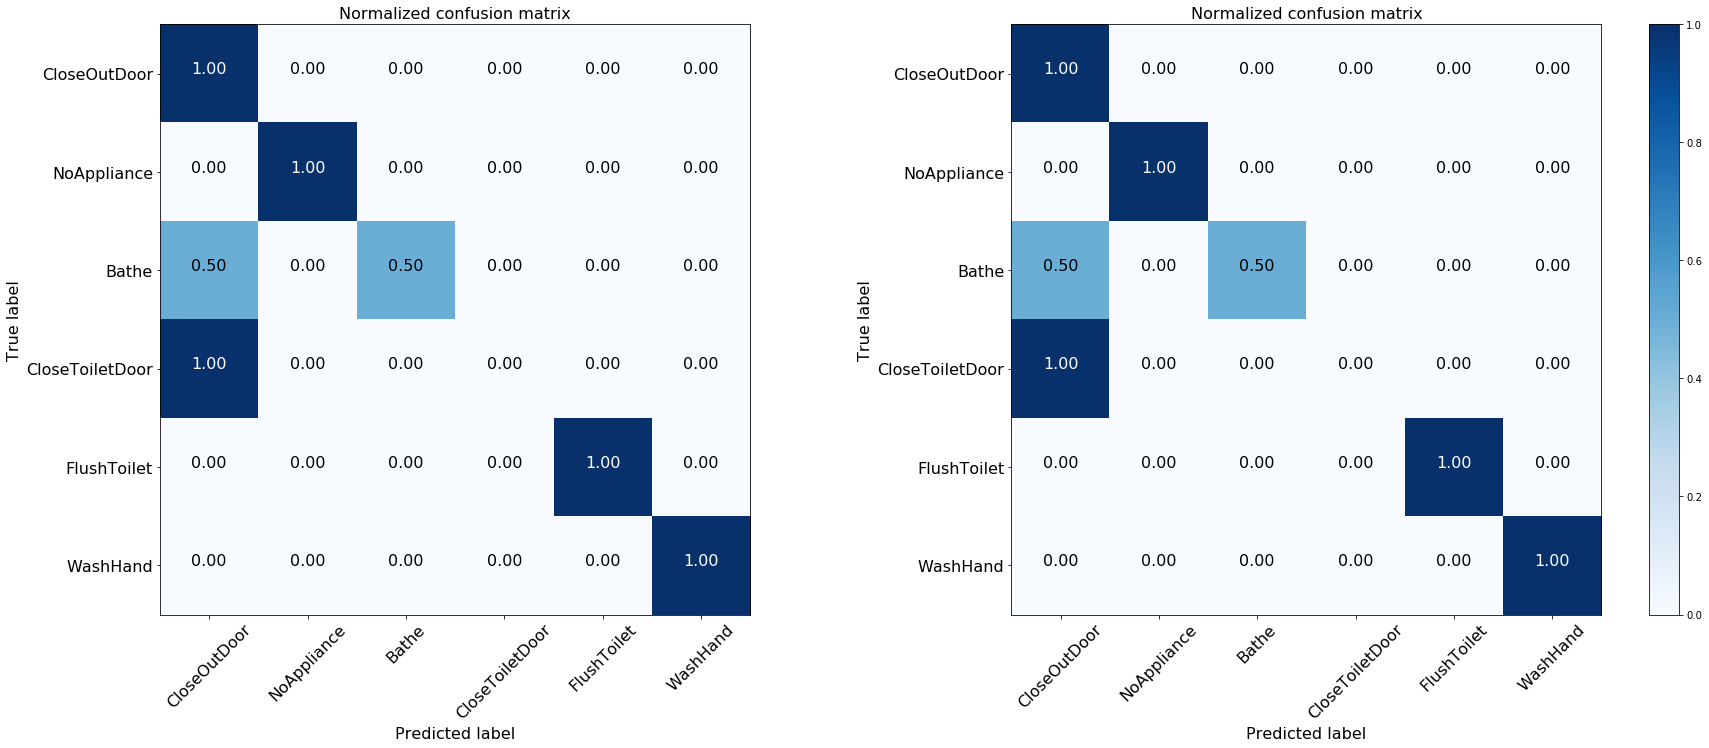

<class 'sklearn.svm.classes.SVC'> accuracy: 61.76%


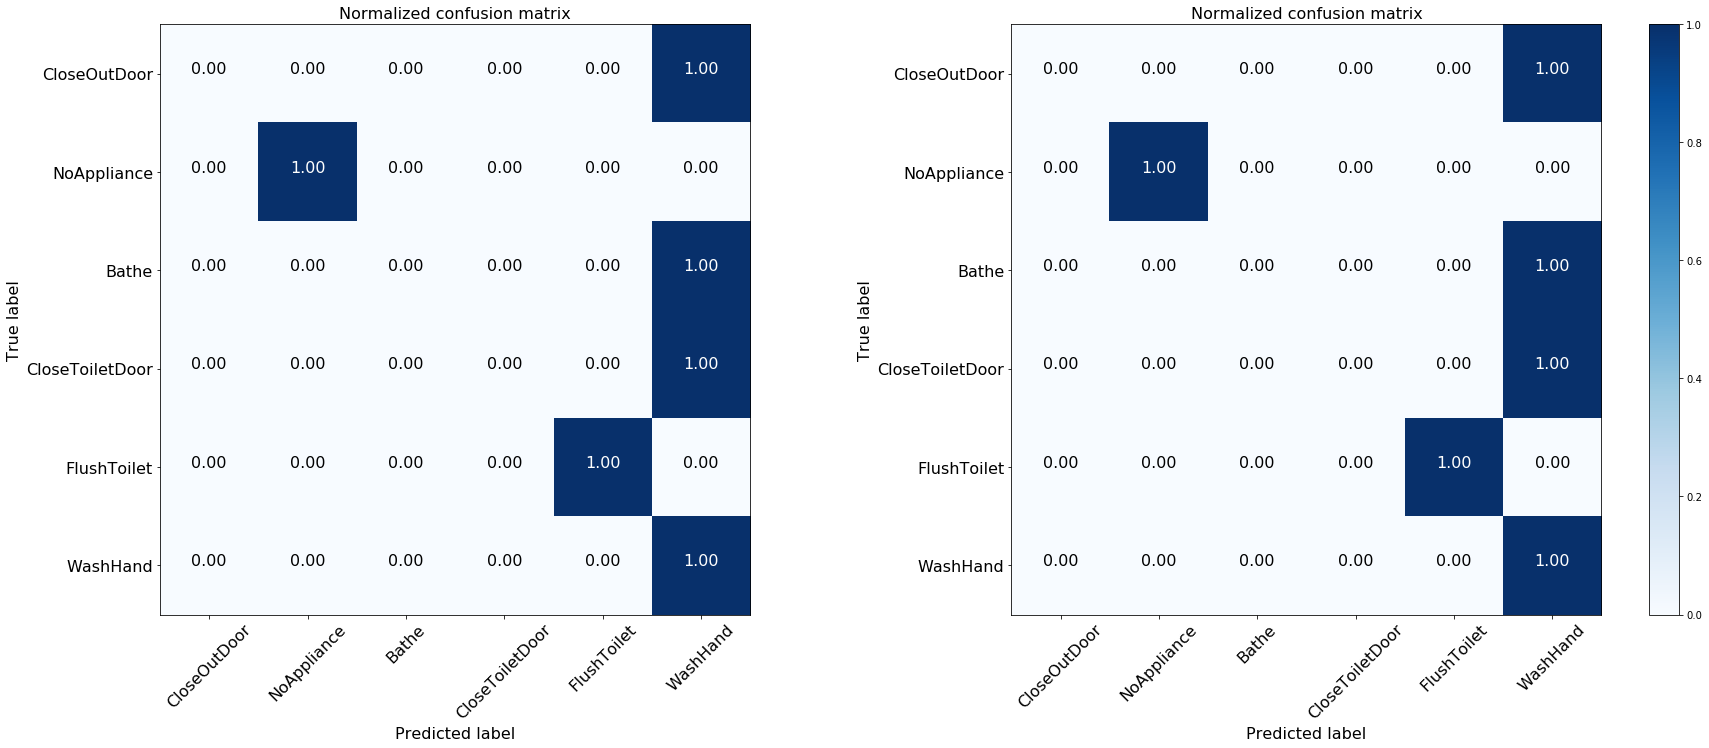

<class 'sklearn.ensemble.forest.RandomForestClassifier'> accuracy: 91.18%


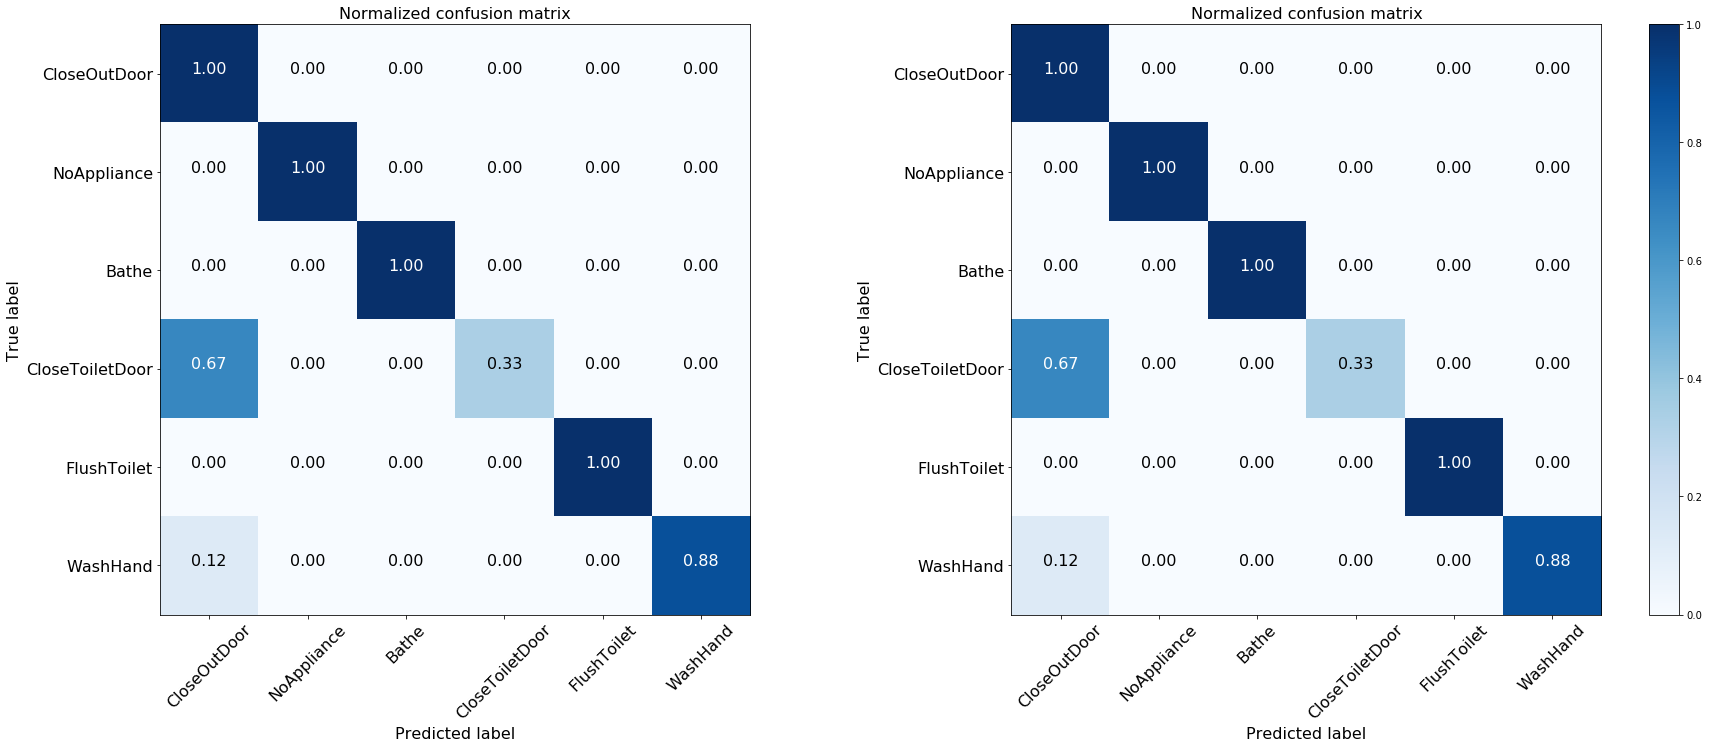

In [221]:
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def model_and_plot(model ,X_train, y_train, X_test, y_test):
    clf = model()
    y_test_pred = clf.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(str(model) + " accuracy: %.2f%%" % (accuracy * 100.0))
    plot_both_confusion_matrix(y_test,y_test_pred)
    
model_and_plot(KNeighborsClassifier, X_train, y_train, X_test, y_test)
model_and_plot(SVC, X_train, y_train, X_test, y_test)
model_and_plot(RandomForestClassifier, X_train, y_train, X_test, y_test)